In [13]:
from scipy.io import loadmat
from scipy import stats
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [16]:
# Get all run data
# subjexts x sessions x runs
run_jx = []
run_jy = []
run_sitmdir = []
run_tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
run_att = []
run_coh = []


for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            run_data = get_run(subj, sess, run)
            run_jx.append(run_data["joyx"])
            run_jy.append(run_data["joyy"])
            run_sitmdir.append(run_data["stimDirREAL"])

            f_tgonset = run_data["f_precuedur"] + run_data["f_cuedur"]
            run_tgonset.append(f_tgonset)

            run_att.append(run_data["attCue"])
            run_coh.append(run_data["tgCoh"])

# Shape the run data
run_jx = np.array(run_jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
run_jy = np.array(run_jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
run_sitmdir = np.array(run_sitmdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
run_tgonset = np.array(run_tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
run_att = np.array(run_att).reshape(n_subjects, n_sessions, n_runs, n_trials)
run_coh = np.array(run_coh).reshape(n_subjects, n_sessions, n_runs, n_trials)

run_jx.shape, run_jy.shape, run_sitmdir.shape, run_tgonset.shape

100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


((13, 4, 6, 120, 500), (13, 4, 6, 120, 500), (13, 4, 6, 120), (13, 4, 6, 120))

In [19]:
# preallocate empty array and assign slice by chrisaycock
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [23]:
# shif by tgonset
shifted_jx = np.zeros_like(run_jx)
shifted_jy = np.zeros_like(run_jy)

shifted_jx[:] = np.nan
shifted_jy[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                tgonset = run_tgonset[sub, sess, run, trial]
                shifted_jx[sub, sess, run, trial, :] = shift(run_jx[sub, sess, run, trial, :], -1*tgonset, fill_value=np.nan)
                shifted_jy[sub, sess, run, trial, :] = shift(run_jy[sub, sess, run, trial, :], -1*tgonset, fill_value=np.nan)

In [24]:
# Distance from center

run_dist_from_cent = np.sqrt(run_jx ** 2 + run_jy ** 2)
run_dist_from_cent[np.isnan(run_dist_from_cent)] = 0

dist_from_cent = np.sqrt(shifted_jx ** 2 + shifted_jy ** 2)
dist_from_cent[np.isnan(dist_from_cent)] = 0

In [25]:
# max distance indexs
max_idx = np.argmax(dist_from_cent, axis=-1)

In [29]:
maxed_jx = np.zeros_like(shifted_jx)
maxed_jy = np.zeros_like(shifted_jy)

maxed_jx[:] = np.nan
maxed_jy[:] = np.nan

# Take everything till the max distance
for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                end_idx = max_idx[sub,sess,run,trial]
                maxed_jx[sub,sess,run, trial,:end_idx] = shifted_jx[sub,sess,run, trial,:end_idx]
                maxed_jy[sub,sess,run, trial,:end_idx] = shifted_jy[sub,sess,run, trial,:end_idx]

In [31]:
def plot_runs(stimdir, x, y, sub, sess, run):
    plt.figure(figsize=(6, 4))
    for i in range(120): 
        if stimdir[sub,sess,run,i] == 159.0:
            color = 'r'
        elif stimdir[sub,sess,run,i] == 123.0:
            color = 'g'
        elif stimdir[sub,sess,run,i] == 87.0:
            color = 'b'
        elif stimdir[sub,sess,run,i] == 51.0:
            color = 'y'
        elif stimdir[sub,sess,run,i] == 15.0:
            color = 'k'

        plt.plot(x[sub,sess,run, i,:], y[sub,sess,run, i,:], '-', color=color, alpha=0.2)
    # outside the plot to the right
    plt.legend(['159 - red', '123 - green', '87 - blue', '51 - yellow', '15 - black'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

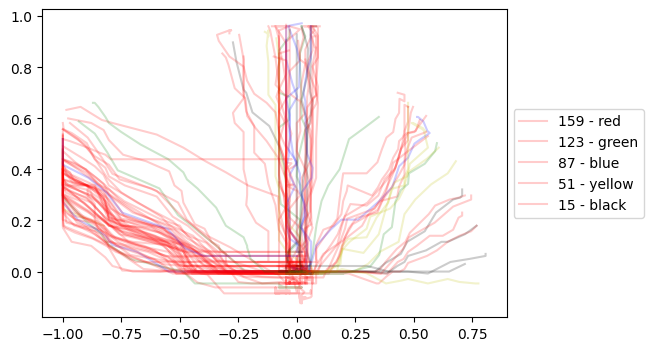

In [41]:
plot_runs(run_sitmdir, maxed_jx, maxed_jy, 12, 3, 0)

In [42]:
# From the first instance of distance = 1, make everything after that nan
# This is to remove the overshoot

bound_jx = np.zeros_like(maxed_jx)
bound_jy = np.zeros_like(maxed_jy)

bound_jx[:] = np.nan
bound_jy[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                clip_ts = 500

                for timestep in range(n_ts):
                    if dist_from_cent[sub,sess,run,trial,timestep] >= 1:
                        # something bigger than one found
                        clip_ts = timestep
                        break

                bound_jx[sub,sess,run,trial,:clip_ts] = maxed_jx[sub,sess,run,trial,:clip_ts]
                bound_jy[sub,sess,run,trial,:clip_ts] = maxed_jy[sub,sess,run,trial,:clip_ts]


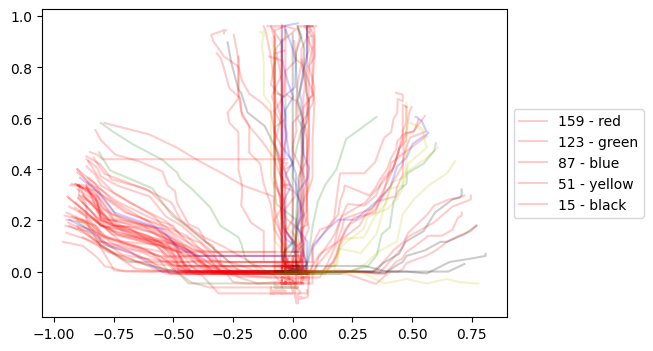

In [43]:
plot_runs(run_sitmdir, bound_jx, bound_jy, 12, 3, 0)

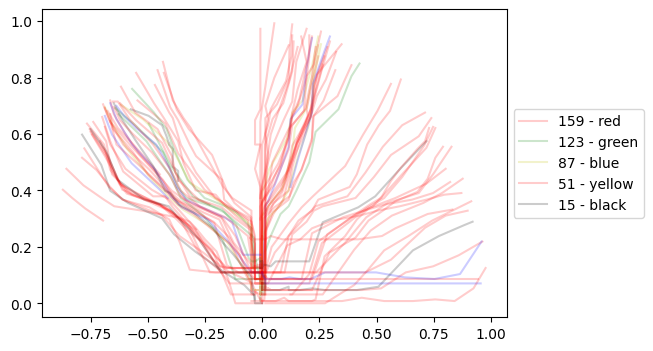

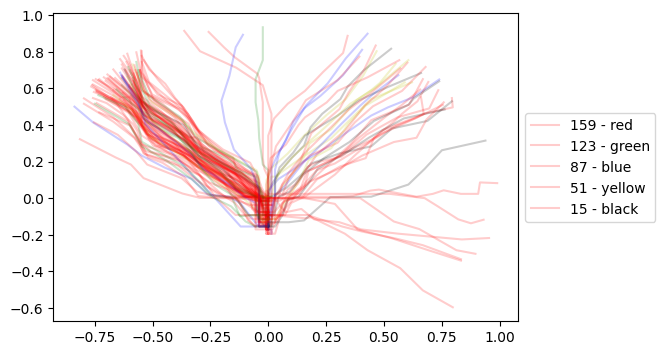

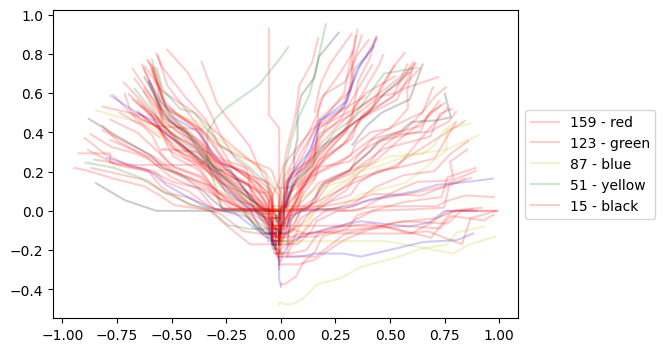

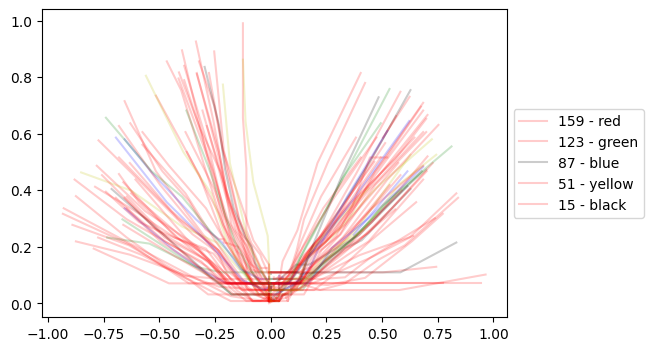

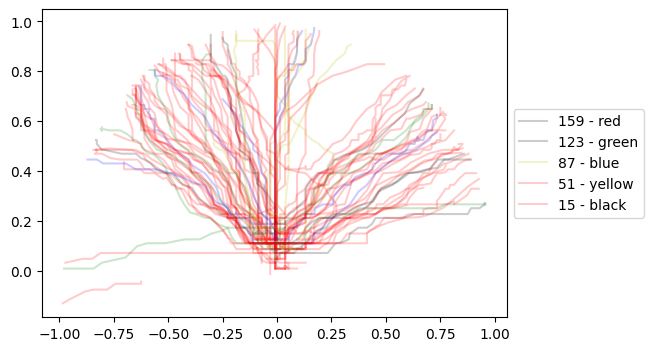

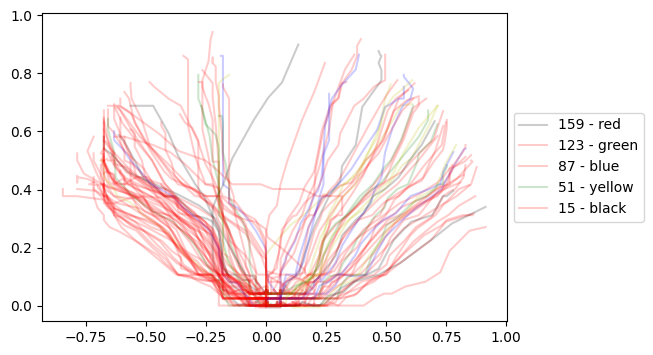

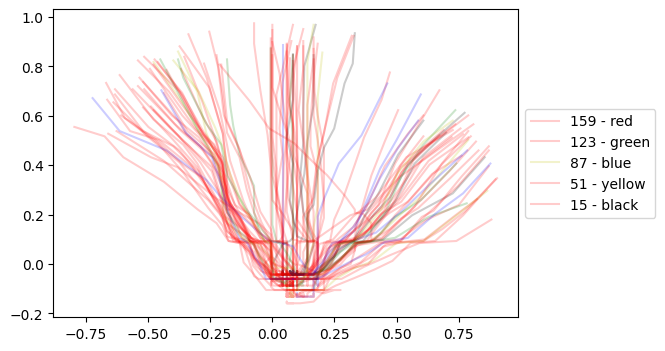

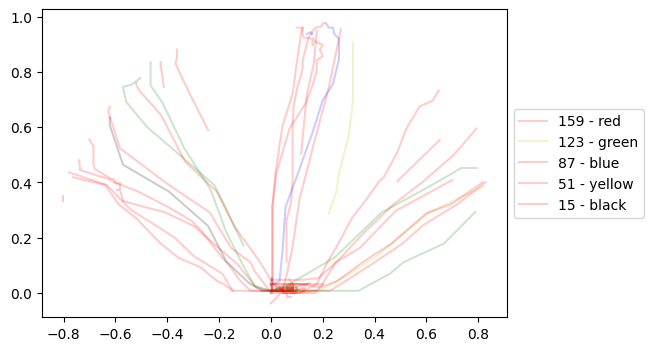

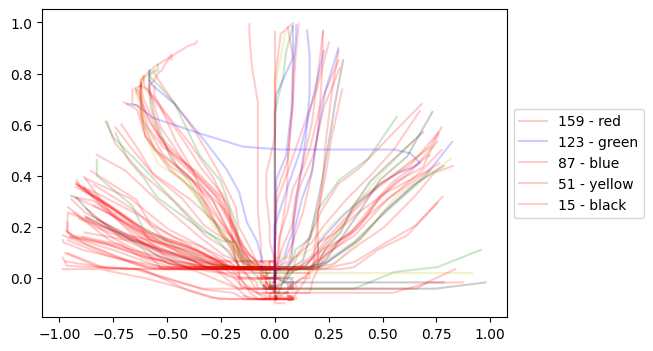

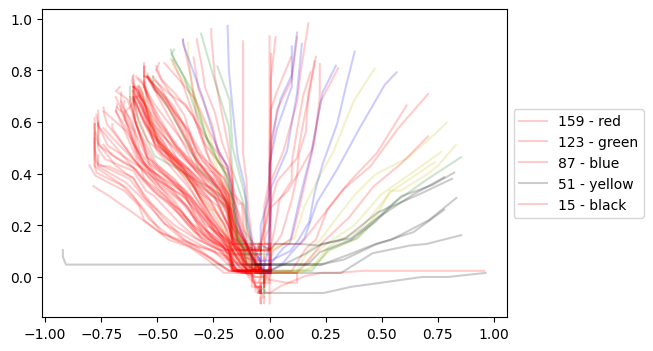

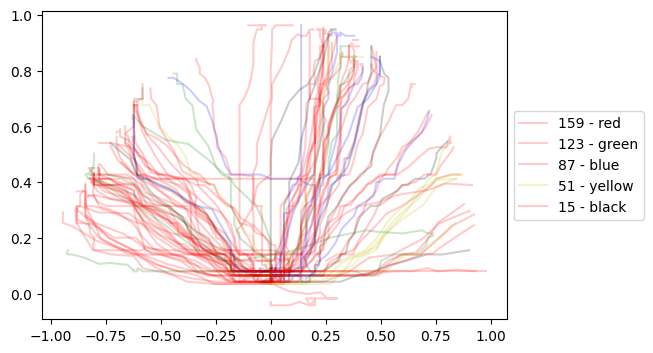

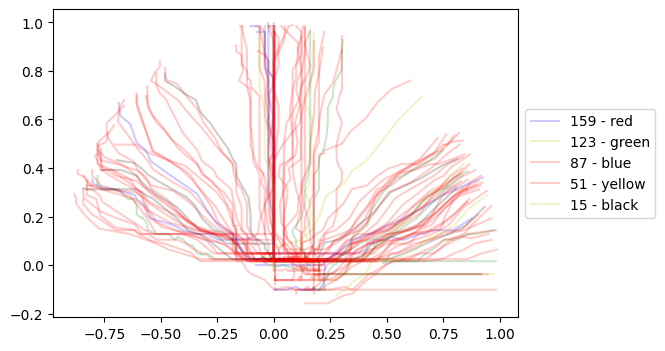

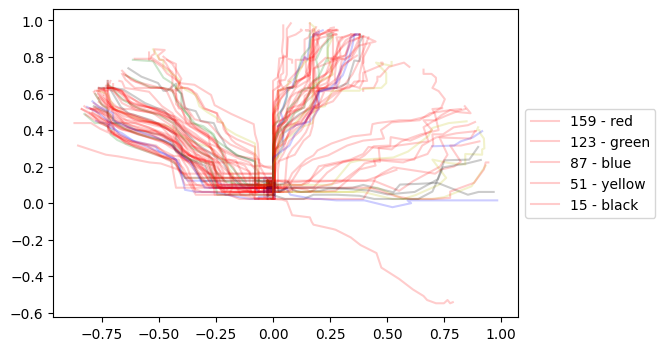

In [44]:
# checking all subjects
for sub in range(n_subjects):
    plot_runs(run_sitmdir, bound_jx, bound_jy, sub, 0, 0)

In [45]:
# Calculate response angle
bound_resp = np.arctan2( bound_jy.flatten(), bound_jx.flatten() )
bound_resp = np.rad2deg(bound_resp)
bound_resp = (bound_resp + 360) % 360;
bound_resp = bound_resp.reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)

In [46]:
def plot_trial(resp,stimdir, jx, jy, sub, sess, run, trial):

    _, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(resp[sub,sess,run,trial,:])
    axs[0].plot(stimdir[sub,sess,run,trial]*np.ones(500))
    axs[0].set(xlabel='TS', ylabel='Response Angle (deg)')

    # at each point in the plot, write the corresponding response angle
    axs[1].plot(jx[sub,sess,run,trial,:], jy[sub,sess,run,trial,:])
    for i in range(500):
        # skip if not a number
        if np.isnan(jx[sub,sess,run,trial,i]):continue
        axs[1].text(jx[sub,sess,run,trial,i], jy[sub,sess,run,trial,i], str(round(resp[sub,sess,run,trial,i], 2)), fontsize=8)
    axs[1].set(xlabel='JoyX', ylabel='JoyY')

    plt.show()

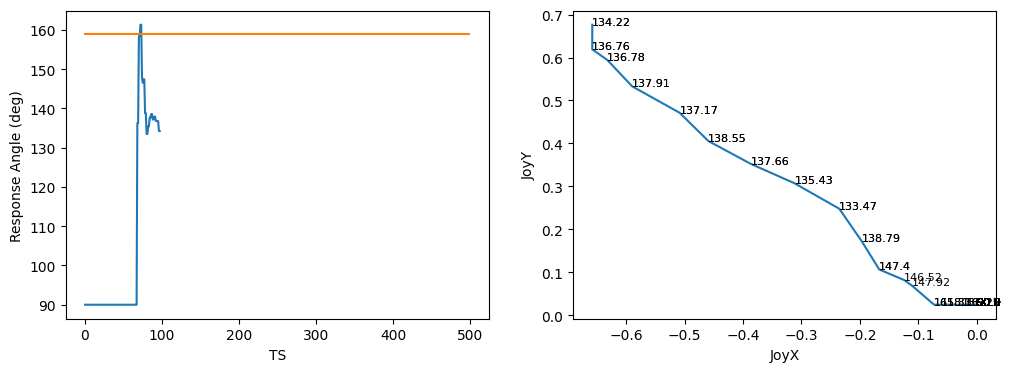

In [48]:
plot_trial(bound_resp, run_sitmdir, bound_jx, bound_jy, 5, 0, 0, 14)

## looking at errors

In [50]:
# get error angle over time

error_angle = np.zeros_like(bound_resp)
error_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                a = run_sitmdir[sub,sess,run,trial]
                for ts in range(n_ts):
                    if np.isnan(bound_resp[sub,sess,run,trial,ts]):continue
                    b = bound_resp[sub,sess,run,trial,ts]
                    error_angle[sub,sess,run,trial,ts] = min(abs(a-b), 360-abs(a-b))

In [121]:
calib_median = np.load("../calib_results/circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

calib_median[0,median_key[15]]

18.752775869814286

In [123]:
# get error angle over time

calib_error_angle = np.zeros_like(bound_resp)
calib_error_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                t = run_sitmdir[sub,sess,run,trial]
                a = calib_median[sub,median_key[t]]
                for ts in range(n_ts):
                    if np.isnan(bound_resp[sub,sess,run,trial,ts]):continue
                    b = bound_resp[sub,sess,run,trial,ts]
                    calib_error_angle[sub,sess,run,trial,ts] = min(abs(a-b), 360-abs(a-b))

In [53]:
# find which complete run in erros has all null values

null_idx = []
for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                if np.all(np.isnan(error_angle[sub,sess,run,trial])):
                    null_idx.append((sub, sess,run, trial))

In [67]:
f"{(len(null_idx) / (error_angle.flatten().shape[0]/500)) * 100} % of the data is answered incorrectly"

'7.323717948717949 % of the data is answered incorrectly'

In [146]:
null_idx[-5:]

[(12, 3, 0, 93),
 (12, 3, 1, 90),
 (12, 3, 3, 65),
 (12, 3, 4, 43),
 (12, 3, 4, 96)]

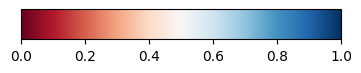

In [72]:
import pylab as pl
a = np.array([[0,1]])
pl.figure(figsize=(4, 0.5))
img = pl.imshow(a, cmap="RdBu")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)

In [74]:
def plot_steps(sub, sess, run, trial):

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].scatter(run_jx[sub,sess,run,trial,:], run_jy[sub,sess,run,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[0].plot(run_jx[sub,sess,run,trial,:], run_jy[sub,sess,run,trial,:], 'k')
    axs[0].set(xlabel='JoyX', ylabel='JoyY')
    axs[0].set_title('Raw')

    axs[1].scatter(maxed_jx[sub,sess,run,trial,:], maxed_jy[sub,sess,run,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[1].plot(maxed_jx[sub,sess,run,trial,:], maxed_jy[sub,sess,run,trial,:], 'k')
    axs[1].set(xlabel='JoyX', ylabel='JoyY')
    axs[1].set_title('Maxed')

    axs[2].scatter(bound_jx[sub,sess,run,trial,:], bound_jy[sub,sess,run,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[2].plot(bound_jx[sub,sess,run,trial,:], bound_jy[sub,sess,run,trial,:], 'k')
    axs[2].set(xlabel='JoyX', ylabel='JoyY')
    axs[2].set_title('Bounded')

    # set limit
    axs[0].set_xlim(-1.1, 1.1)
    axs[1].set_xlim(-1.1, 1.1)
    axs[2].set_xlim(-1.1, 1.1)

    axs[0].set_ylim(-0.1, 1.1)
    axs[1].set_ylim(-0.1, 1.1)
    axs[2].set_ylim(-0.1, 1.1)

    plt.show()

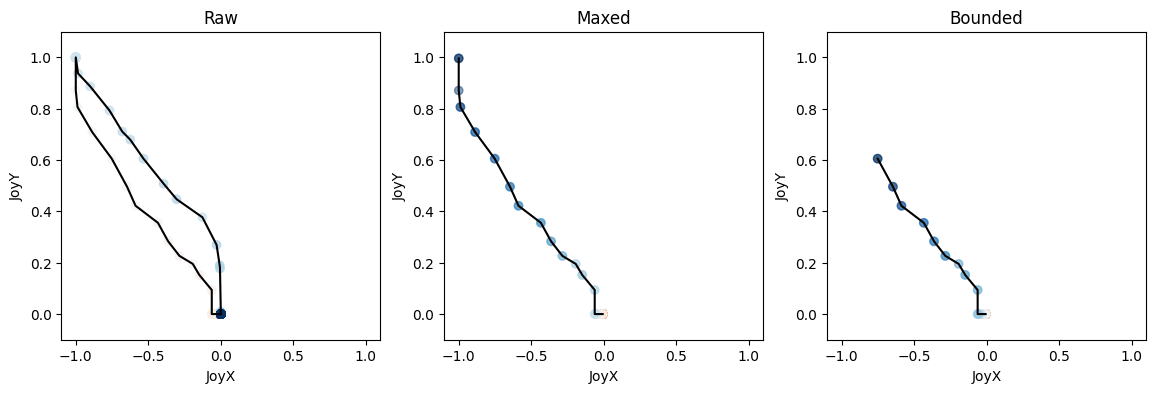

In [75]:
plot_steps(0, 2, 0, 0)

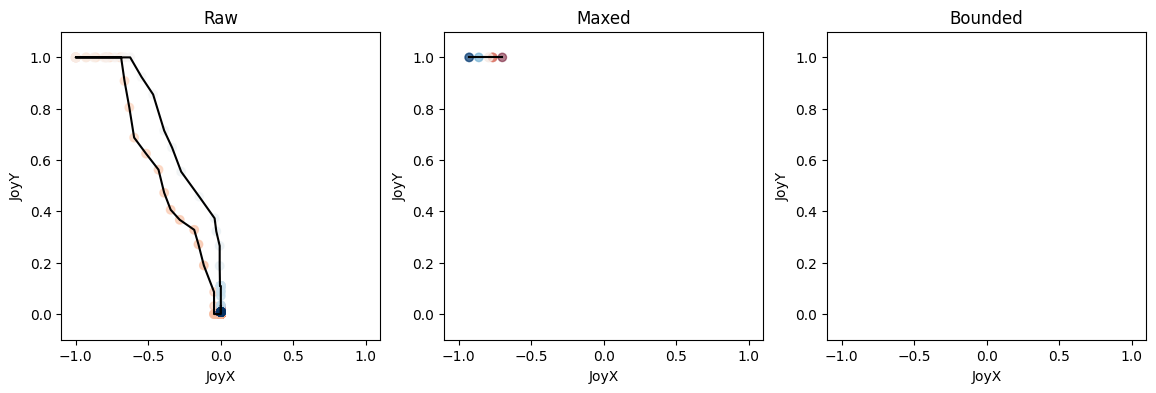

In [76]:
plot_steps(0, 0, 0, 2) 

In [77]:
def plot_dist(sub, sess, run, trial):

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    axs[0].plot(run_dist_from_cent[sub,sess,run,trial,:])
    axs[0].set(xlabel='TS', ylabel='Distance from Center')
    axs[0].set_title('raw')
    # vertical line at tgonset
    axs[0].plot([run_tgonset[sub,sess,run,trial], run_tgonset[sub,sess,run,trial]], [0, 1.4], 'k--', lw=1)

    axs[1].plot(dist_from_cent[sub,sess,run,trial,:])
    axs[1].set(xlabel='TS', ylabel='Distance from Center')
    axs[1].set_title('shifted')

    plt.show()

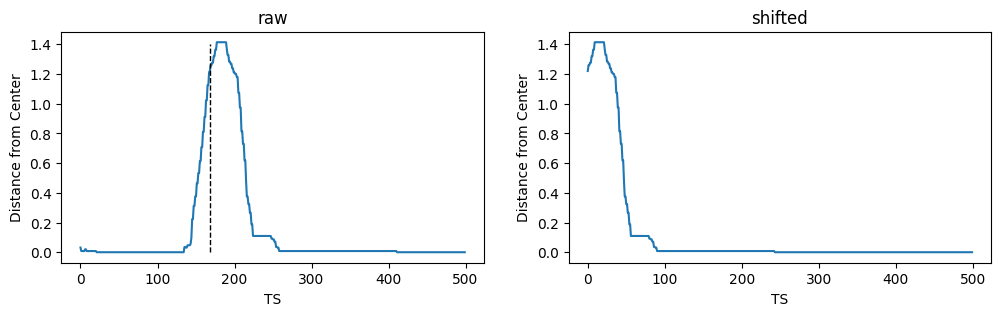

In [78]:
plot_dist(0, 0, 0, 2) 

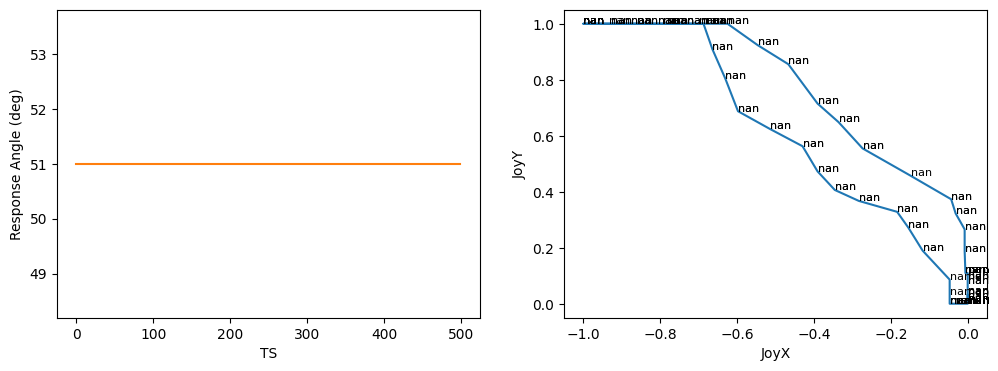

In [88]:
plot_trial(bound_resp, run_sitmdir, run_jx, run_jy, 0, 0, 0, 2)

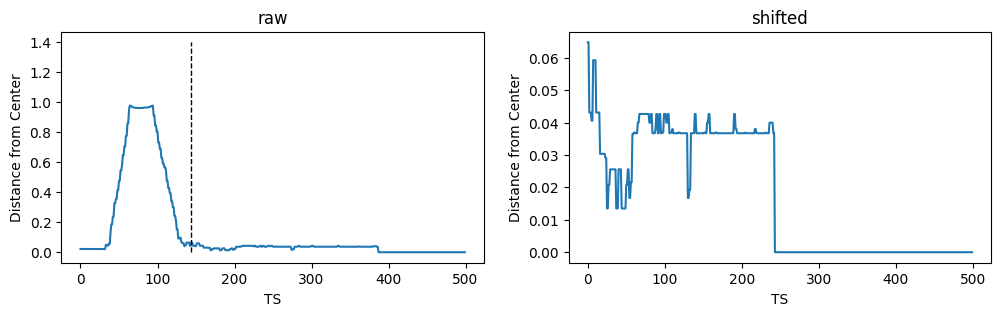

In [148]:
plot_dist(12, 3, 4, 43)

In [89]:
# these responses are thrown out

In [90]:
# Take the erros and mean across trials
mean_error_angle = np.nanmean(error_angle, axis=(1,2,3))

/tmp/ipykernel_26374/445317760.py:2: RuntimeWarning: Mean of empty slice
  mean_error_angle = np.nanmean(error_angle, axis=(1,2,3))


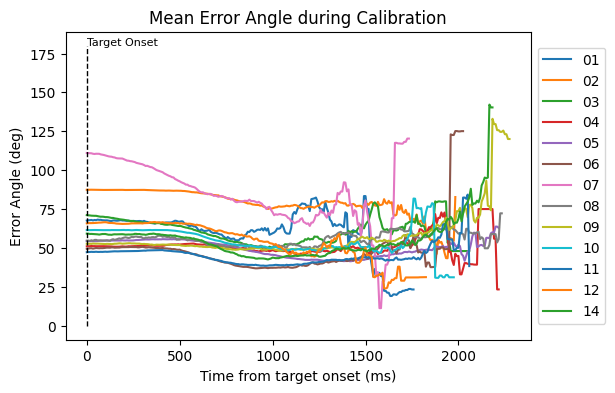

In [91]:
fr = 1000/120

plt.figure(figsize=(6, 4))
for sub in range(n_subjects):
    plt.plot(np.array(range(500))*fr, mean_error_angle[sub,:])
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Mean Error Angle during Calibration')
# legend out of plot
plt.legend(subjects, loc='center left', bbox_to_anchor=(1, 0.5))

# Add note that 0 is the point of target onset
plt.plot([0, 0], [0, 180], 'k--', lw=1)
plt.text(0, 180, 'Target Onset', fontsize=8)

plt.show()

/tmp/ipykernel_26374/1225506238.py:8: RuntimeWarning: Mean of empty slice
  plt.plot(np.array(range(x_crop))*fr, np.nanmean(error_angle, axis=(0,1,2,3))[:x_crop], 'g--')
/tmp/ipykernel_26374/1225506238.py:9: RuntimeWarning: Mean of empty slice
  plt.plot(np.array(range(x_crop))*fr, np.nanmean(calib_error_angle, axis=(0,1,2,3))[:x_crop], 'g-')


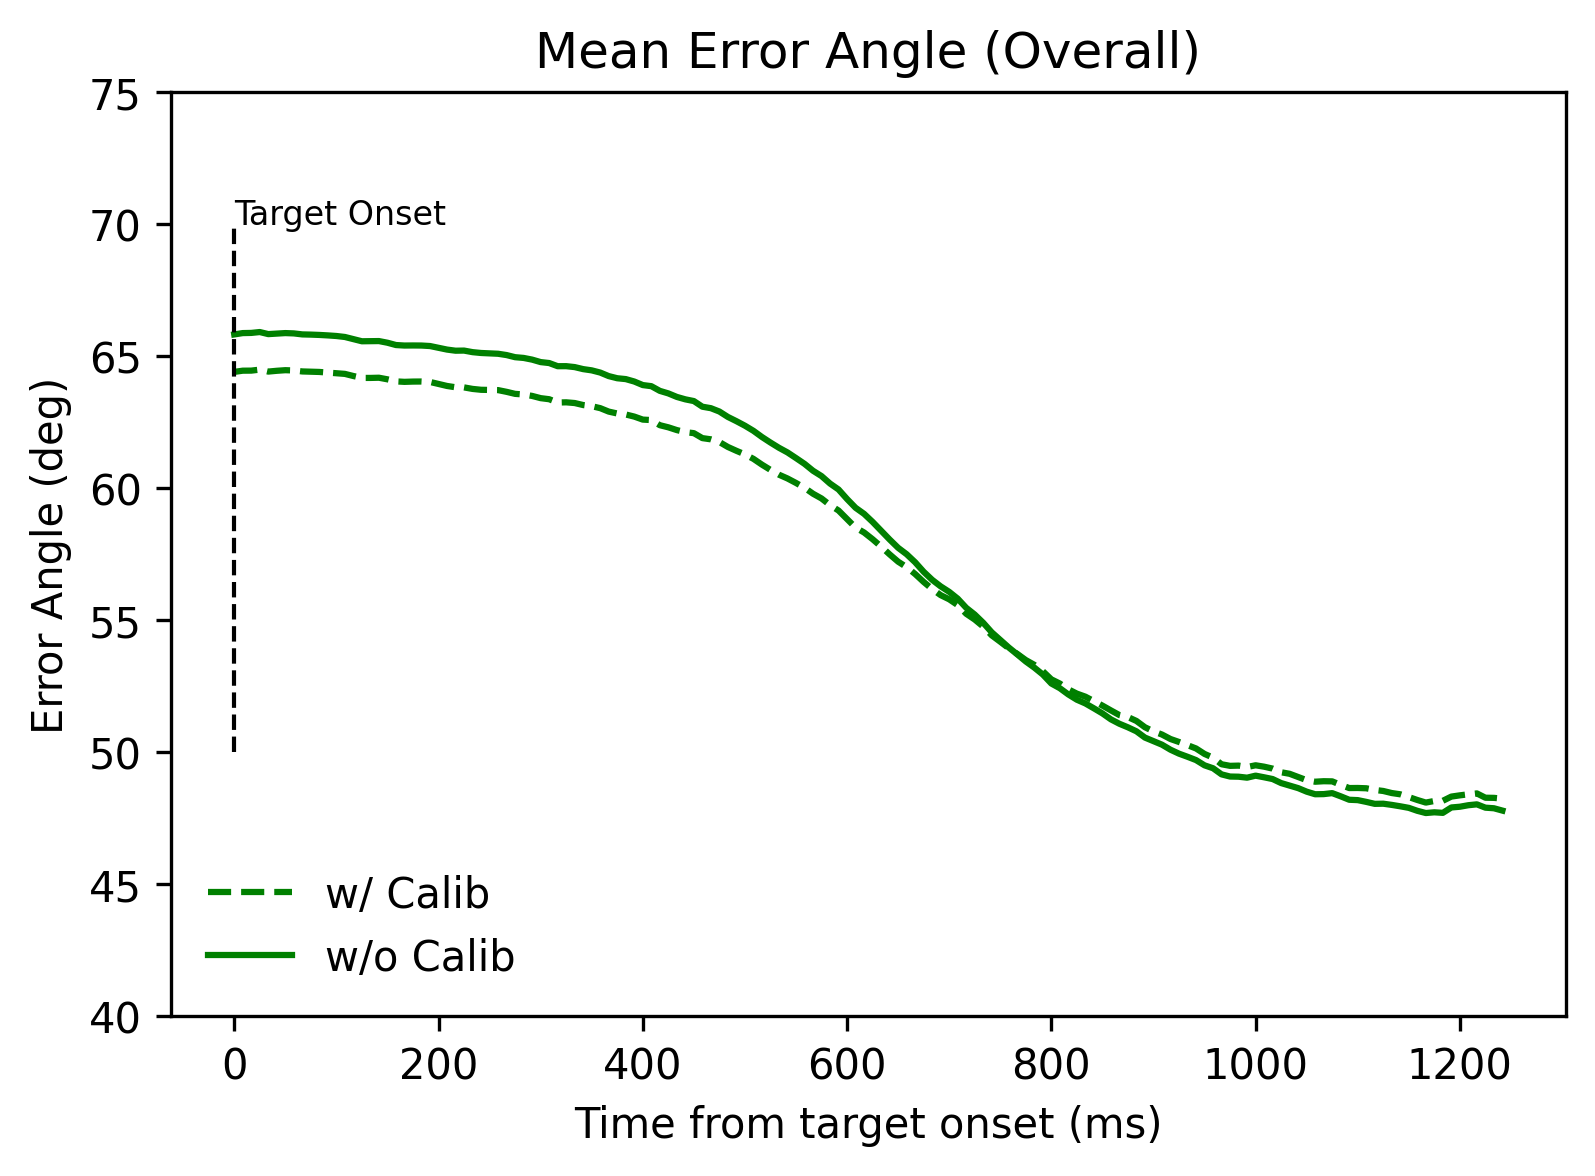

In [143]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(np.array(range(x_crop))*fr, np.nanmean(error_angle, axis=(0,1,2,3))[:x_crop], 'g--')
plt.plot(np.array(range(x_crop))*fr, np.nanmean(calib_error_angle, axis=(0,1,2,3))[:x_crop], 'g-')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Mean Error Angle (Overall)')

plt.legend(['w/ Calib', 'w/o Calib'], loc='lower left', frameon=False)

plt.ylim(40, 75)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

## Getting response angles

In [29]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [30]:
# Get the last non nan values as the response angle

last_resp_angle = np.zeros((n_subjects, n_sessions, n_trials))
last_resp_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for trial in range(n_trials):
            for ts in range(n_ts):
                if np.isnan(bound_resp[sub,sess,trial,ts]):
                    last_resp_angle[sub,sess,trial] = bound_resp[sub,sess,trial,ts - 1]
                    break

In [31]:
# check if there are any nan values, these are to be ignored duing calculation
np.argwhere(np.isnan(last_resp_angle))

array([[0, 2, 0],
       [9, 2, 0]])

In [32]:
# organize the response angles by stimdir
last_resp_angle.shape, calib_sitmdir.shape

((13, 4, 120), (13, 4, 120))

In [33]:
np.unique(calib_sitmdir)

array([ 15,  51,  87, 123, 159], dtype=uint8)

In [34]:
# 5 angles in total and each subject has 4 * 120/ 5 = 96 trials per angle
stim_resp = np.zeros((n_subjects, 5, 96))

for sub in range(n_subjects):
    # for each unique stimdir
    for i, unique_stim in enumerate(np.unique(calib_sitmdir)):
        # get the response angle for that stimdir by masking the calib_sitmdir with the unique stimdir
        stim_resp[sub, i] = last_resp_angle[sub][calib_sitmdir[sub]==unique_stim]

stim_resp.shape

(13, 5, 96)

In [35]:
# now calculate the circular std and median for each subject and angle

In [90]:
circ_median = np.zeros((n_subjects, 5))
circ_std = np.zeros((n_subjects, 5))

for sub in range(n_subjects):
    for i, unique_stim in enumerate(np.unique(calib_sitmdir)):
        circ_median[sub, i] = circmedian(stim_resp[sub, i])
        circ_std[sub, i] = np.rad2deg(stats.circstd(np.deg2rad(stim_resp[sub, i]), nan_policy='omit'))

In [102]:
pd.DataFrame(circ_median, index=subjects, columns=np.unique(calib_sitmdir))

,15,51,87,123,159
01,18.752776,32.872185,64.547658,138.718044,145.877462
02,36.980188,46.453086,69.256176,134.912042,141.796043
03,15.381696,56.109639,84.890123,124.461200,150.908946
04,15.891056,49.407544,89.413314,116.323690,148.362786
05,24.064663,37.322810,73.671086,137.406108,150.699476
06,19.011896,39.561438,67.231716,126.823716,150.723443
07,21.510639,37.859579,80.765188,126.798660,140.451473
08,16.351909,37.877136,82.692124,123.008761,143.720457
09,1.391104,37.853070,75.131218,125.861780,159.645274
10,23.204631,43.472421,90.349254,128.369081,144.699391


In [101]:
pd.DataFrame(circ_std, index=subjects, columns=np.unique(calib_sitmdir))

,15,51,87,123,159
01,9.022259,6.036654,11.451835,11.305999,5.991948
02,13.999590,9.031298,10.230571,6.295155,6.187493
03,11.285967,16.563402,10.860686,7.583460,15.032226
04,11.103439,9.864909,5.499348,9.707438,11.805849
05,11.188028,11.455831,10.927331,13.463108,11.376268
06,9.045171,8.031650,9.005004,7.638255,8.869109
07,11.444128,10.556542,8.340564,16.090199,9.332095
08,8.426546,8.591857,9.724702,8.920830,10.002457
09,4.381122,9.617331,7.465239,7.386025,10.322298
10,11.450448,14.947350,12.002168,10.773861,11.288203


In [108]:
# np.save('circ_median.npy', circ_median)  

In [109]:
# np.save('circ_std.npy', circ_std)